In [1]:
# minist dataset: http://yann.lecun.com/exdb/mnist/

from torchvision.datasets import MNIST
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
train = MNIST("./data/", train=True, download=True) #60000
test= MNIST("./data/",train=False, download=True) #10000

label:  0
size:  (28, 28)
max pixle value:  255


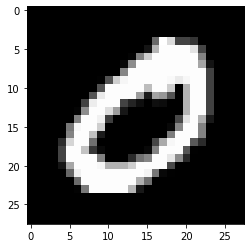

In [4]:
# show random train sample
num = np.random.randint(len(train))

plt.imshow(train[num][0], cmap='gray')
print("label: ", train[num][1])

print("size: ", train[num][0].size)

print("max pixle value: ", np.max(train[num][0]))

## Network 

In [95]:
import math

class Conv2d():
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = [kernel_size,kernel_size] if isinstance(kernel_size, int) \
                           else [int(x) for x in kernel_size]
        self.stride = [stride,stride] if isinstance(stride, int) else [int(x) for x in stride]
        self.padding = [padding,padding] if isinstance(padding, int) else [int(x) for x in padding]
        # TODO:Xavier initialize weight
        #CHW
        self.kernels = [np.random.rand(in_channels,kernel_size,kernel_size) for i in range(out_channels)] 
    def __call__(self,x):
        # CHW
        in_c ,in_h, in_w= x.shape 
        out_h = math.floor( (in_h + 2*self.padding[0] - self.kernel_size[0])/self.stride[0] + 1)
        out_w = math.floor( (in_w + 2*self.padding[1] - self.kernel_size[1])/self.stride[1]+ 1)
        
        print("output shape",out_h,out_w,len(self.kernels),out_h*out_w*len(self.kernels))
        
        values = []
        if (self.padding[0])or(self.padding[1]):
            zeroMat = np.zeros((in_c,in_h+2*self.padding[0],in_w+2*self.padding[1]))
            zeroMat[:,self.padding[0]:-self.padding[0],self.padding[1]:-self.padding[1]] = x[:,:,:]
            x = zeroMat
            print(x.shape)
            in_c ,in_h, in_w= x.shape 
        
        for kernel in self.kernels:
            for i in range(0,in_w,self.stride[1]):
                for j in range(0,in_h,self.stride[0]):
                    i_ = i+self.kernel_size[1]
                    j_ = j+self.kernel_size[0]
                    if (i_>in_w) or (j_>in_h):
                        continue
                    else:
                        #conv
                        val = (x[:,j:j_,i:i_]*kernel).sum()
#                         print(val)
                        values.append(val)
        print(len(values))
        # CHW
        output = np.array(values).reshape(self.out_channels,out_h,out_w)
        print(output.shape)
        return output

                

In [96]:
#test Conv2d
conv1 = Conv2d(3,28,5,3,3)
dummy_input = np.random.rand(3,110,110)
conv1(dummy_input)

output shape 38 38 28 40432
(3, 116, 116)
40432
(28, 38, 38)


array([[[ 3.12955263,  8.23993135,  8.92879583, ...,  6.59626291,
          8.09060123,  3.28685362],
        [ 7.45435867, 18.68478599, 18.94584829, ..., 17.94953715,
         18.19203917,  6.12887427],
        [ 8.22285149, 16.82078298, 17.68187298, ..., 18.89041845,
         16.45254779,  6.17283341],
        ...,
        [ 7.58368437, 17.30817446, 18.55860474, ..., 17.23195151,
         18.24716544,  5.8369749 ],
        [ 7.31960809, 18.32721242, 20.4956346 , ..., 17.44756344,
         16.43674023,  7.29278231],
        [ 3.3053818 ,  7.00767673,  7.42618404, ...,  7.20853386,
          6.40831742,  2.544015  ]],

       [[ 2.63307179,  8.08848452,  9.05666232, ...,  6.75674482,
          6.67479538,  4.57268347],
        [ 8.01183491, 20.55674619, 20.60358656, ..., 21.8658194 ,
         20.25834665,  9.78476864],
        [ 8.23210471, 19.91244533, 21.16637808, ..., 21.05269853,
         19.39260337,  8.34346685],
        ...,
        [ 7.01543957, 22.2037604 , 21.32604891, ..., 2

In [72]:
39*39*2

3042

In [73]:
[np.random.rand(2,2,2) for i in range(3)] 

[array([[[0.44888424, 0.06940141],
         [0.99892552, 0.72149652]],
 
        [[0.12718963, 0.05024143],
         [0.22137483, 0.92347845]]]),
 array([[[0.9618739 , 0.55767691],
         [0.03898568, 0.25044422]],
 
        [[0.83345027, 0.15314205],
         [0.40826096, 0.89972952]]]),
 array([[[0.46240453, 0.69024476],
         [0.87231417, 0.0024989 ]],
 
        [[0.71264834, 0.50865012],
         [0.29670563, 0.12158693]]])]

In [38]:
kernel = np.random.rand(3,3,1)

In [39]:
x.shape

(5, 5, 1)

In [40]:
kernel

array([[[0.32295891],
        [0.36178866],
        [0.22826323]],

       [[0.29371405],
        [0.63097612],
        [0.09210494]],

       [[0.43370117],
        [0.43086276],
        [0.4936851 ]]])

In [7]:
for i in range(0,10,2):
    print(i)

0
2
4
6
8


In [50]:
(x[0:3,0:3]*kernel).sum()

1.865895708470751

In [51]:
x[0:3,1:4]

array([[[0.28613933],
        [0.22685145],
        [0.55131477]],

       [[0.9807642 ],
        [0.68482974],
        [0.4809319 ]],

       [[0.72904971],
        [0.43857224],
        [0.0596779 ]]])

In [52]:
(x[0:3,1:4]*kernel).sum()

1.5994163112883744

In [53]:
(x[0:3,2:5]*kernel).sum()

1.390098858176254

In [55]:
_ = []
for i in range(x.shape[0]):
    i_ = i+kernel.shape[0]
    for j in range(x.shape[1]):
        j_ = j+kernel.shape[1]
        if (i_ > x.shape[0]) or (j_ > x.shape[1]):
            continue
        filed = x[i:i_,j:j_]
        _.append(filed)
        print(filed)

[[[0.69646919]
  [0.28613933]
  [0.22685145]]

 [[0.42310646]
  [0.9807642 ]
  [0.68482974]]

 [[0.34317802]
  [0.72904971]
  [0.43857224]]]
[[[0.28613933]
  [0.22685145]
  [0.55131477]]

 [[0.9807642 ]
  [0.68482974]
  [0.4809319 ]]

 [[0.72904971]
  [0.43857224]
  [0.0596779 ]]]
[[[0.22685145]
  [0.55131477]
  [0.71946897]]

 [[0.68482974]
  [0.4809319 ]
  [0.39211752]]

 [[0.43857224]
  [0.0596779 ]
  [0.39804426]]]
[[[0.42310646]
  [0.9807642 ]
  [0.68482974]]

 [[0.34317802]
  [0.72904971]
  [0.43857224]]

 [[0.73799541]
  [0.18249173]
  [0.17545176]]]
[[[0.9807642 ]
  [0.68482974]
  [0.4809319 ]]

 [[0.72904971]
  [0.43857224]
  [0.0596779 ]]

 [[0.18249173]
  [0.17545176]
  [0.53155137]]]
[[[0.68482974]
  [0.4809319 ]
  [0.39211752]]

 [[0.43857224]
  [0.0596779 ]
  [0.39804426]]

 [[0.17545176]
  [0.53155137]
  [0.53182759]]]
[[[0.34317802]
  [0.72904971]
  [0.43857224]]

 [[0.73799541]
  [0.18249173]
  [0.17545176]]

 [[0.63440096]
  [0.84943179]
  [0.72445532]]]
[[[0.72904971

In [56]:
len(_)

9

In [38]:
import cv2



In [39]:
!ls

data		       pytorch_convNet.onnx	      README.md
numpy_convNet.ipynb    pytorch_convNet-polished.onnx
pytorch_convNet.ipynb  pytorch_convNet.pth


In [40]:
!ls

data		       pytorch_convNet.onnx	      README.md
numpy_convNet.ipynb    pytorch_convNet-polished.onnx
pytorch_convNet.ipynb  pytorch_convNet.pth
